Импорт

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as ps
import plotly.graph_objects as go
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import statsmodels.api as sm

#дс по аренде велосипедов
df = pd.read_csv("DataSet5_2.csv", sep=",")
df.head()

,count,holiday,humidity,registered,summer,temp,windspeed,workingday
0,2,0,81,2,0,10.66,22.0028,1
1,157,0,54,150,1,18.04,16.9979,1
2,233,0,40,199,1,37.72,15.0013,1
3,98,0,88,86,1,22.14,19.0012,1
4,6,0,74,6,0,6.56,6.0032,1


Деление на тестовую и обучающую выборки


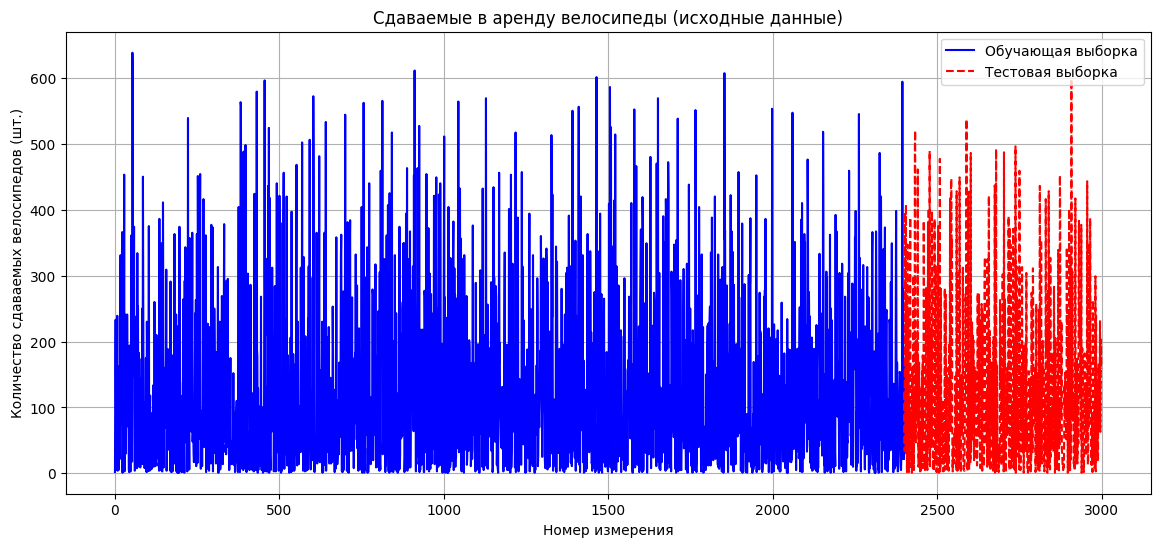

In [77]:
#деление на тест. и обуч. выборки

oby4 = round(0.8*len(df))
train = df[:oby4]
test = df[oby4:]

fig = go.Figure()

plt.figure(figsize=(14, 6))
plt.plot(train['count'].index, train['count'], color = 'blue', label='Обучающая выборка', linestyle = 'solid')
plt.plot(test['count'].index, test['count'], color = 'red', label='Тестовая выборка',linestyle = 'dashed')

plt.xlabel('Номер измерения')
plt.ylabel('Количество сдаваемых велосипедов (шт.)')
plt.title('Сдаваемые в аренду велосипеды (исходные данные)')
plt.grid()
plt.legend()
plt.show()

Целевая переменная и признаки

In [78]:
X_train = train.drop(['count'], axis=1, inplace=False)
y_train = train['count']

X_test = test.drop(['count'], axis=1, inplace=False)
y_test = test['count']

Регрессионная модель

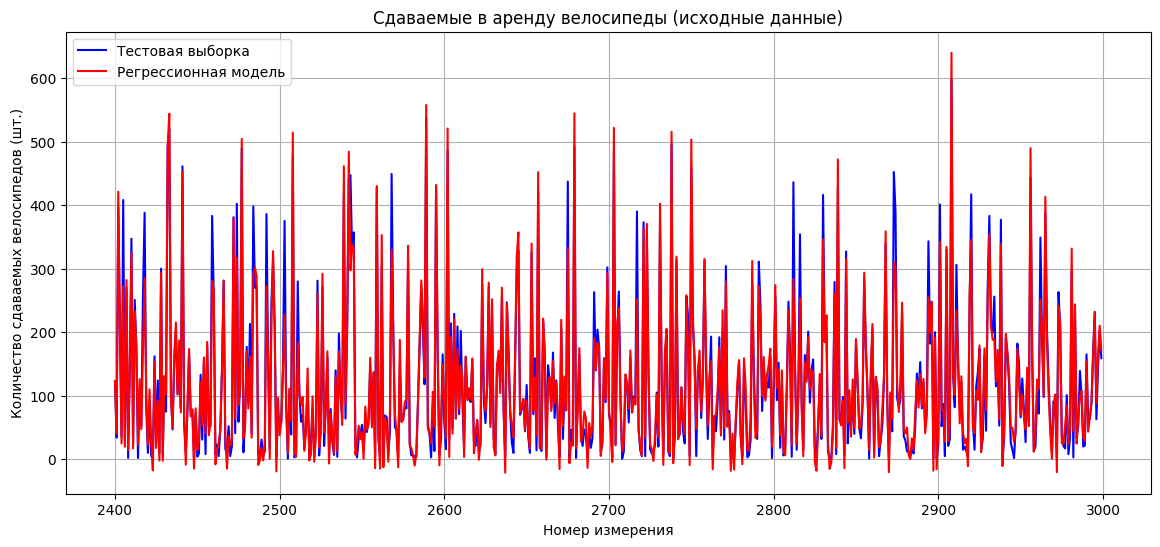

In [79]:
from scipy.optimize import curve_fit

# Определение функции для квадратичной аппроксимации
def func(x, c0, c1, c2, c3, c4,c5,c6,c7):
    return (c0 + c1 * x['holiday'] + c2 * x['humidity'] + c3 * x['registered'] + c4 * x['summer'] + c5*x['temp'] + c6*x['windspeed'] +c7*x['workingday'])

popt, _ = curve_fit(func, X_train, y_train)
c0, c1, c2, c3, c4, c5, c6, c7 = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7]

res_y_train = func(train, c0, c1, c2, c3, c4,c5,c6,c7)
res_y_test = func(test, c0, c1, c2, c3, c4,c5,c6,c7)
res_general_y = list(res_y_train) + list(res_y_test)

plt.figure(figsize=(14, 6))
plt.plot(test['count'].index, test['count'], color = 'blue', label='Тестовая выборка',linestyle = 'solid')
plt.plot(test['count'].index, res_y_test, color = 'red', label='Регрессионная модель',linestyle = 'solid')

plt.xlabel('Номер измерения')
plt.ylabel('Количество сдаваемых велосипедов (шт.)')
plt.title('Сдаваемые в аренду велосипеды (исходные данные)')
plt.grid()
plt.legend()
plt.show()


Построение с сортировкой по "количеству арендованных велосипедов"

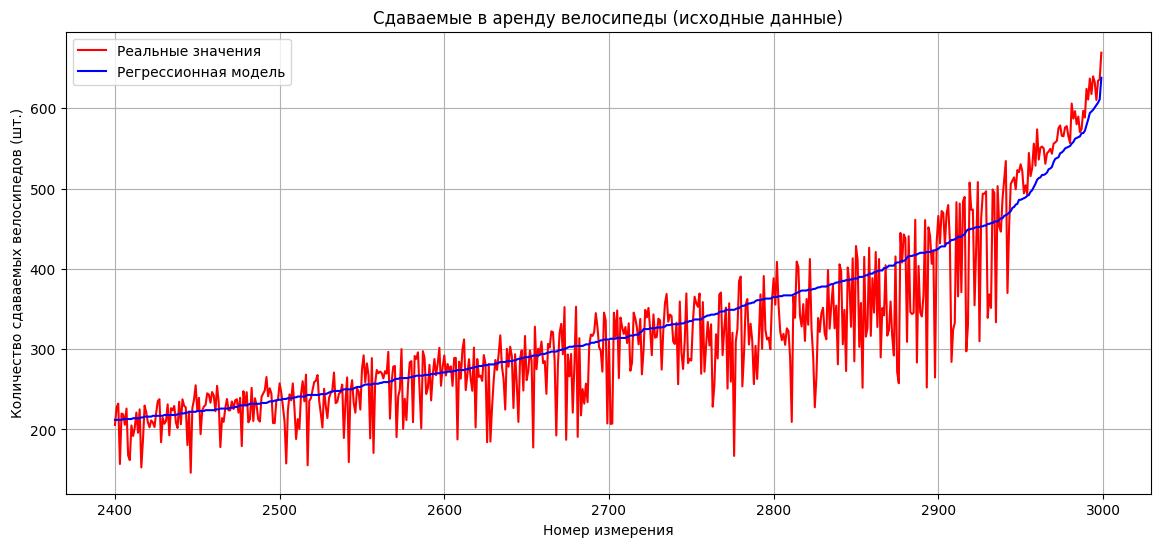

In [80]:
df_sort = df.sort_values(by='count').reset_index()
test2 = df_sort[oby4:]

X_test_sort = test2.drop(['count'], axis=1, inplace=False)
res_y_test_sort = func(X_test_sort, c0, c1, c2, c3, c4,c5,c6,c7)

plt.figure(figsize=(14, 6))

plt.plot(test2['count'].index, res_y_test_sort, color = 'red', label='Реальные значения',linestyle = 'solid')
plt.plot(test2['count'].index, test2['count'], color = 'blue', label='Регрессионная модель',linestyle = 'solid')

plt.xlabel('Номер измерения')
plt.ylabel('Количество сдаваемых велосипедов (шт.)')
plt.title('Сдаваемые в аренду велосипеды (исходные данные)')
plt.grid()
plt.legend()
plt.show()

Преобразование значений в категории

In [81]:
#бинарные 0 и 1

df3 = pd.DataFrame()
df4 = pd.DataFrame()

df3 = [1 if df['count'][i] > 100 else 0 for i in range(len(df))]
df4 = [1 if res_general_y[i] > 100 else 0 for i in range(len(res_general_y))]

#print(df3)
#print(df4)

Метрики

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(df3,df4)*100 #оценка доли классифицированных положительных объектов являющихся положительными (точность предсказания)
recall = recall_score(df3,df4)*100 # оценка найденных моделью доли всех положительных объектов (насколько хорошо обнаруживает)
accuracy = accuracy_score(df3,df4)*100 # общая точность классификации образцов
f1 = f1_score(df3,df4)*100 # гармоническое среднее точности и полноты (баланс точности и полноты)
roc_auc = roc_auc_score(df3,df4)*100 # измеряет общую способность классификатора разделять положительные и отрицательные случаи, рассматривая весь диапазон возможных пороговых значений

print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"roc_auc: {roc_auc}")

precision: 93.65411436541143
recall: 98.1008035062089
accuracy: 96.1
f1: 95.82590082054942
roc_auc: 96.26070218228901


ROC-кривая (ROC-кривая отображает отношение между долей ложных срабатываний (FPR) и долей истинных положительных (TPR) для разных пороговых значений классификации)

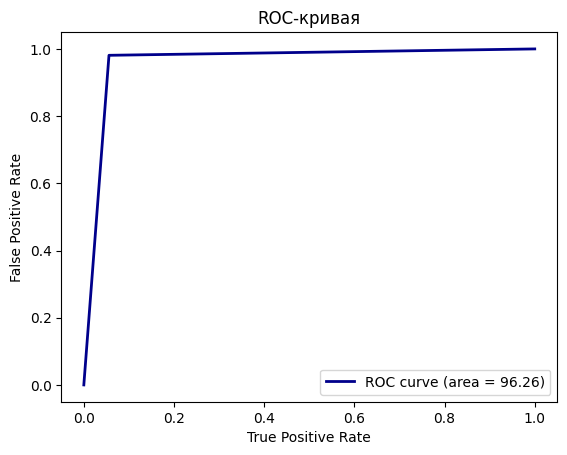

In [83]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df3,df4)

#строим график рок-кривой
plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

Классифицкая

In [84]:
from sklearn.neighbors import KNeighborsClassifier
#алгоритм с k-ближайшими соседями (хорошо подходит под модели классификации)

df_k = df
df_k['k'] = [1 if df['count'][i] > 100 else 0 for i in range(len(df))]

#обучающая выборка
X_train_k = df_k.drop(['k'], axis=1,inplace=False)[:oby4]
y_train_k = df_k['k'][:oby4]

neigh = KNeighborsClassifier(n_neighbors=3) #создаем экземляр классификатора (в данном случае 3 ближ. соседа)
neigh.fit(X_train_k, y_train_k) #обучаем

#целевой столбец
target = df_k['k']
train_full = df_k.drop(['k'], axis=1,inplace=False)
res_k = neigh.predict(train_full)

precision = precision_score(target,res_k)*100
call = recall_score(target,res_k)*100
accuracy = accuracy_score(target,res_k)*100
f1 = f1_score(target,res_k)*100 
roc_auc = roc_auc_score(target,res_k)*100

print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"roc_auc: {roc_auc}")

precision: 99.27007299270073
recall: 98.1008035062089
accuracy: 99.36666666666667
f1: 99.30631617378604
roc_auc: 99.36473252213885


ROC-кривая

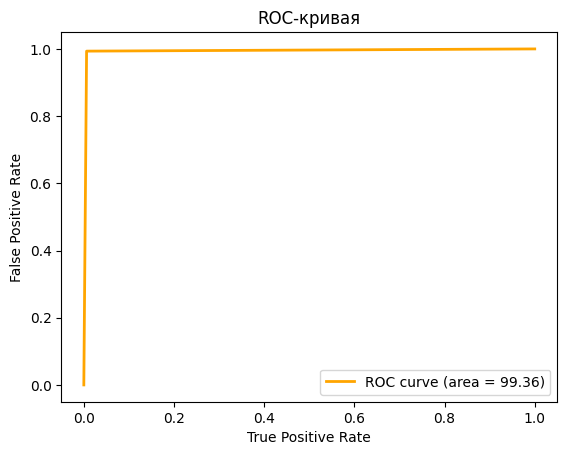

In [85]:
fpr, tpr, thresholds = roc_curve(target,res_k)

#строим график рок-кривой
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()